<a href="https://colab.research.google.com/github/kvelez-iastate/S2021_ME592/blob/Homework3/Homework3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 3

April 9th, 2021

Kimberly Velez

Kyle Swanton

**Motivation**

This homework is to provide an experience of deep learning using simple networks applied to datasets relevant to each theme group.

**Expected Outcome**
1. A code pushed in git(bitbucket).
2. A presentation video explaining the problem and results (duration must not be more
than 10 mins); we will present this video for some groups in class.

**Design and Manufacturing**

Flow stress prediction at different strain, strain-rate, and temperatures is required for
warm forming of sheet metals. In simulations, this 
ow stress is very important for
accurate simulations. Specifically for materials like Austenitic Stainless Steel which shows
a Dynamic Strain Ageing phenomenon at moderately high temperatures. In this regime,
the behavior of materials is wavy and cannot be understood well with current physical
models and phenomenological models. So, in this homework we would be trying to
accurately predict 
ow stress based on deep learning models you have learnt till now.
You will build a Long Short Term Memory (LSTM) network for this assignment.

In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
os.symlink('/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3', nb_path)
sys.path.insert(0, nb_path)

Mounted at /content/mnt


In [2]:
import sys
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


import re
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from torch.nn import LSTM


## Define Functions

In [3]:
#%% helper functions

def generate_X_and_Y(data, poly_degree):
    # split data into features (X) and target variable (Y)
    X = data[['plastic_strain','temperature','strain_rate']]
    Y = data['true_stress']
    
    # normalize the features (X)
    X = X.values
    min_max_scaler = preprocessing.MinMaxScaler()
    X_scaled = min_max_scaler.fit_transform(X)
    X = pd.DataFrame(X_scaled)
    
    # generate polynomial features
    poly = PolynomialFeatures(degree = poly_degree)
    X = poly.fit_transform(X)
    
    # cast the training data as tensors
    X = torch.tensor(X).float()
    Y = torch.tensor(Y.values).float()
    return X, Y

def read_sort_input(file):
    # import the data from file name
    data = pd.read_excel(file, keep_default_na=False)
    # remove empty columns
    data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
    # grab the file name only to pull metadata
    filename = file.split('\\')[-1]
    
    # if plastic strain is available, use it; otherwise use true strain
    if len(data.columns) == 8:        
        stress_strain = data.iloc[:,6:8]
        stress_strain.columns = ['strain', 'stress']
    else:
        stress_strain = data.iloc[:,4:6]
        stress_strain.columns = ['strain', 'stress']
        print(filename)
    
    # remove the data points where both plastic strain and true stress are zero
    index_names = stress_strain[ (stress_strain['strain'] < 0.01) | (stress_strain['stress'] < 20) ].index
    stress_strain.drop(index_names, inplace=True)
    
    stress_strain_np = stress_strain.to_numpy()
    stress_strain = pd.DataFrame({'strain':stress_strain_np[:,0],'stress':stress_strain_np[:,1]})
        
    # pulling apart the filename, which has metadata
    filename_split = filename.split('.')
    # pulling out the temperature as only a number
    temp = "".join(filter(str.isdigit, filename_split[0][0:-1]))
    #combining metadata of temperature and strainrate from file name
    tempstrain = pd.DataFrame({'temperature': temp,'strainrate': filename_split[1]},index=list(range(len(stress_strain.iloc[1:,0])+1)))
    
    # combining strain, stress, temperature, and strainrate
    combined = pd.concat([stress_strain['strain'],tempstrain,stress_strain['stress']], axis=1)
    combined_tensor = torch.tensor(combined.to_numpy(dtype=float)) 
    
    # this next part of the function rearranges the strain data for the LSTM section
    strain = combined['strain'].to_numpy()
    
    # number of strain columns that we want 
    numCol = 5
    
    # start the strain array so that we can append later
    strain_rearrange = np.zeros((1,numCol))
    
    # rearrange the strain so that each row is numCol number of strain values
    # each column iterates one strain value
    for i in range(0,len(strain)-numCol-1):
        row = np.array(strain[i:i+numCol])
        strain_rearrange = np.vstack((strain_rearrange,row))
        
    strain_rearrange_df = pd.DataFrame(strain_rearrange[1:,:])  
    stress_rearrange = combined['stress'][numCol:]
    stress_rearrange.reset_index(drop=True, inplace=True)
    
    tempstrain = pd.DataFrame({'temperature': temp,'strainrate': filename_split[1]},index=list(range(len(strain_rearrange)-1)))
    combined_strain = pd.concat([strain_rearrange_df,tempstrain,stress_rearrange], axis=1)
    combined_strain_tensor = torch.tensor(combined_strain.to_numpy(dtype=float))  
    
    return combined, combined_tensor, combined_strain, combined_strain_tensor

def list_folder_contents(path):
    
    # initialize an empty list
    entries = []
    
    # loop through the folder to retieve its contents
    for entry in os.listdir(path):
        entries.append(entry)
        
    # return the folder contents
    return entries

def list_to_tensor(listdata):
    tensordata = listdata[0]
    for i in range(len(listdata)-1):
        tensordata = torch.cat((tensordata, listdata[i+1]))
        
    return tensordata

Set global inputs

In [4]:
# inputs
path = r'/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM'
plastic_strain_tol = 0.01
true_stress_tol = 2
column_names = ['plastic_strain', 'true_stress']
test_temperatures = [150, 550]


# neural network parameters
hidden_dim_1 = 10
hidden_dim_2 = 10
poly_degree = 6
hidden_dim = 3
learning_rate = 3E-4
n_folds = 5
poly_degree = 2

## Naive Learning | Data Loading and Pre-Processing

**Data Loading:** 

Load the data provided in the Excel Sheets. Dierent Excel sheets
represent the behavior of the material at different strain rates and temperatures.
Each Excel sheet contains the data about the variation of stress with strain. You
may use, just the true stress vs. plastic strain data for the analysis. (You might
have to preprocess the points by removing some points with zero stress and zero
strain).

**Data preprocessing:** 

Preprocess the data and create a list of strain, strain-rate,
temperature and stress.

In [5]:
#%% read in the data

# loop through sub-directories and make a list of the paths to all data files
file_paths = []
for root, dirs, files in os.walk(path, topdown = True):
   for name in files:
      file_paths.append(os.path.join(root, name))

# initialize an empty dataframe that the raw data can be put into
all_data = pd.DataFrame()

# read each file and append it's data to 'all_data'
for index, file_path in enumerate(file_paths):
    
    # read a single file. 
    # assume that plastic strain data is always in column J
    # assume that true stress data is always in column K
    a = pd.read_excel(file_path, usecols='J:K')
    
    # inconsitent naming convention in the data files. rename for consistancy 
    a.set_axis(column_names, axis=1, inplace=True)
    
    # drop rows where either plastic strain or true stress are close to zero
    index_names = a[(a['plastic_strain']<plastic_strain_tol) & (a['true_stress']<plastic_strain_tol)].index
    a.drop(index_names, inplace=True)
    
    # read the file name
    filename = os.path.basename(file_path)
    
    # split the filename by delimiters. Extract the temperature and strain rate
    filename_split = re.split('-|_|.xls', filename)
    temperature = float(filename_split[0])
    strain_rate = float(filename_split[1])
    
    # add temperature and strain rate columns to the dataframe
    a['temperature'] = temperature
    a['strain_rate'] = strain_rate
    all_data = pd.concat([all_data,a])
    
    # print a status update
    print('read file ', index+1, ' of ', len(file_paths))
  

read file  1  of  43
read file  2  of  43
read file  3  of  43
read file  4  of  43
read file  5  of  43
read file  6  of  43
read file  7  of  43
read file  8  of  43
read file  9  of  43
read file  10  of  43
read file  11  of  43
read file  12  of  43
read file  13  of  43
read file  14  of  43
read file  15  of  43
read file  16  of  43
read file  17  of  43
read file  18  of  43
read file  19  of  43
read file  20  of  43
read file  21  of  43
read file  22  of  43
read file  23  of  43
read file  24  of  43
read file  25  of  43
read file  26  of  43
read file  27  of  43
read file  28  of  43
read file  29  of  43
read file  30  of  43
read file  31  of  43
read file  32  of  43
read file  33  of  43
read file  34  of  43
read file  35  of  43
read file  36  of  43
read file  37  of  43
read file  38  of  43
read file  39  of  43
read file  40  of  43
read file  41  of  43
read file  42  of  43
read file  43  of  43


## Naive Learning | Data Split

**Data split:** 

Split the data pertaining into three parts (training, validation and
testing). Two temperatures can be selected as test data. Choose a strategy to
divide the data for training and validation (a typical strategy is to split the data
into 60% training and 40% testing, or 80-20). Justify the strategy you select. Also,
use k-fold cross validation strategy for training.

In [6]:
# split 'all_data' into train and test
# choose 2 temperatures as test data as per the project requirements
all_data_train = all_data.loc[~all_data['temperature'].isin(test_temperatures)]
all_data_test = all_data.loc[all_data['temperature'].isin(test_temperatures)]

#%% develop a model with k-fold


# define the k-fold
k_fold = KFold(n_splits = n_folds, shuffle=True, random_state=1)

## Naive Learning | Neural Network

**Naive Learning:** 

Considering the strain, strain rate and temperature at every
point, you need to predict the 
ow stress. This can be done by a naive neural
network(fully connected deep neural network, no convolutions).

In [7]:
  # create the model, define the loss function, and optimizer
  model = torch.nn.Sequential(torch.nn.Linear(10,20),torch.nn.ReLU(),torch.nn.Linear(20,1),torch.nn.Flatten(0,1))
  model = model.cuda()
  criterion = torch.nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [8]:
# loop through each fold
for train_index, validate_index in k_fold.split(all_data_train):
    
    # grab the data given the indicies
    all_fold_data_train = all_data_train.iloc[train_index]
    all_fold_data_validate = all_data_train.iloc[validate_index]
    
    # generate X and Y tensors for the training and validating
    X_train, Y_train = generate_X_and_Y(all_fold_data_train, poly_degree)
    X_validate, Y_validate = generate_X_and_Y(all_fold_data_validate, poly_degree)
    X_train = X_train.cuda()
    Y_train = Y_train.cuda()
    X_validate = X_validate.cuda()
    Y_validate = Y_validate.cuda()
    
    # train the model
    for t in range(len(X_train)):
        
        # forward pass
        Y_train_pred = model(X_train)
    
        # compute loss and print
        loss = criterion(Y_train_pred, Y_train)
        if t % 10000 == 99:
            print(t, loss.item()/len(X_train))
        
        # zero gradients, backwards pass, and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # validate the model
    Y_validate_predict = model(X_validate)
    validate_loss = criterion(Y_validate_predict, Y_validate)
    
    # print the results:
    print('---------------')
    print('fold error: ', validate_loss.item()/len(X_validate))
    print('---------------')


99 0.17270221838004698
10099 0.07685833810089339
20099 0.07264015496438614
30099 0.06609952667350398
40099 0.06142186315644058
50099 0.059702591949417336
60099 0.05953232948167521
70099 0.05943145580670733
80099 0.05929587078369285
---------------
fold error:  0.22658903407644418
---------------
99 0.05893877842635078
10099 0.05890647421394929
20099 0.05866774399359761
30099 0.058223350589971995
40099 0.05767230864605152
50099 0.057061512102490365
60099 0.056534507611701944
70099 0.0559817196468558
80099 0.055628108030258756
---------------
fold error:  0.2181161881552606
---------------
99 0.05526142569310239
10099 0.054507752333606246
20099 0.05405015888267526
30099 0.0501605439186648
40099 0.04901938836046532
50099 0.04752467048163492
60099 0.04869817508230727
70099 0.054187991230804616
80099 0.05379434434994619
---------------
fold error:  0.2136733260788432
---------------
99 0.045864300078148505
10099 0.052271210168129585
20099 0.04899094380504027
30099 0.051296167649339225
40099

## Naive Learning | Testing and Deployment

**Deployment:** 

The true stress and true strain results are obtained for a sheet metal.
Tensile testing is performed on a small rectangular strip, 6cm in length and the jaws
holding one end of the specimen and the other side is pulled by a displacement of
x. For all the experiments in the data, displacement is such a way that the strain
rate is constant through out the process. However, in forming strain rate varies
non-linearly. Example: your displacement could be represented as x = t^3 - 2t^2 + t.
Then, predict the stress-strain curve for this profile of displacements. (Hint: you
need to use the Hooke's law and related components to convert the x to strains and
strain rates and then eventually computing the stress strain curve for same).

**Presenting results:** 

Compare the results you obtain for training, validation and
testing data on the naive learning model and the LSTM. Visualize the stress-strain
curves of the predicted (both) and the actual. Also, visualize the stress-strain curve
for the deployment for both the learning cases.


In [9]:
#%% test the model

path_150 = r'/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/150C'
path_550 = r'/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/550C'

# loop through sub-directories and make a list of the paths to all data files
file_paths_150 = []
for root, dirs, files in os.walk(path_150, topdown = True):
   for name in files:
      file_paths_150.append(os.path.join(root, name))

# initialize an empty dataframe that the raw data can be put into
data_150 = []
filename_150 = []

# read each file and append it's data to 'all_data'
for index, file_path in enumerate(file_paths_150):
    
    # read a single file. 
    # assume that plastic strain data is always in column J
    # assume that true stress data is always in column K
    a = pd.read_excel(file_path, usecols='J:K')
    
    # inconsitent naming convention in the data files. rename for consistancy 
    a.set_axis(column_names, axis=1, inplace=True)
    
    # drop rows where either plastic strain or true stress are close to zero
    index_names = a[(a['plastic_strain']<plastic_strain_tol) & (a['true_stress']<plastic_strain_tol)].index
    a.drop(index_names, inplace=True)
    
    # read the file name
    filename = os.path.basename(file_path)
    
    # split the filename by delimiters. Extract the temperature and strain rate
    filename_split = re.split('-|_|.xls', filename)
    temperature = float(filename_split[0])
    strain_rate = float(filename_split[1])
    
    # add temperature and strain rate columns to the dataframe
    a['temperature'] = temperature
    a['strain_rate'] = strain_rate
    data_150.append(a)
    filename_150.append(filename)


file_paths_550 = []
for root, dirs, files in os.walk(path_550, topdown = True):
   for name in files:
      file_paths_550.append(os.path.join(root, name))
      
# initialize an empty dataframe that the raw data can be put into
data_550 = []
filename_550 = []

# read each file and append it's data to 'all_data'
for index, file_path in enumerate(file_paths_550):
    
    # read a single file. 
    # assume that plastic strain data is always in column J
    # assume that true stress data is always in column K
    a = pd.read_excel(file_path, usecols='J:K')
    
    # inconsitent naming convention in the data files. rename for consistancy 
    a.set_axis(column_names, axis=1, inplace=True)
    
    # drop rows where either plastic strain or true stress are close to zero
    index_names = a[(a['plastic_strain']<plastic_strain_tol) & (a['true_stress']<plastic_strain_tol)].index
    a.drop(index_names, inplace=True)
    
    # read the file name
    filename = os.path.basename(file_path)
    
    # split the filename by delimiters. Extract the temperature and strain rate
    filename_split = re.split('-|_|.xls', filename)
    temperature = float(filename_split[0])
    strain_rate = float(filename_split[1])
    
    # add temperature and strain rate columns to the dataframe
    a['temperature'] = temperature
    a['strain_rate'] = strain_rate
    data_550.append(a)
    filename_550.append(filename)

Text(0, 0.5, 'stress')

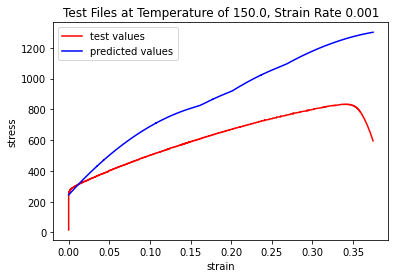

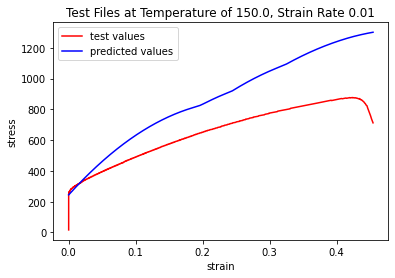

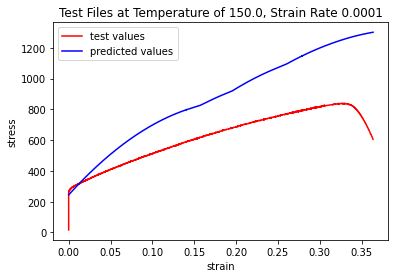

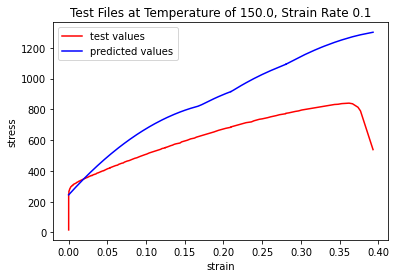

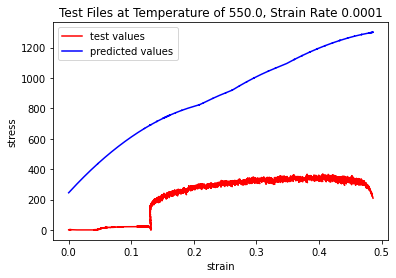

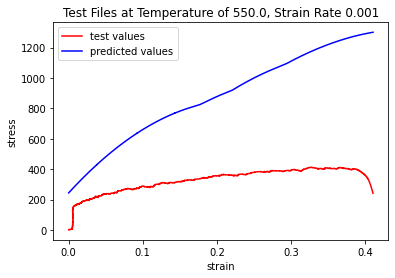

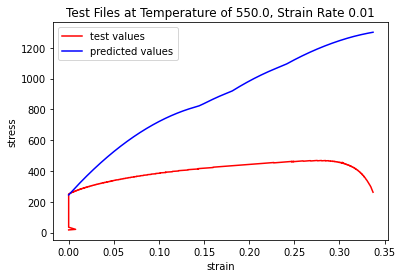

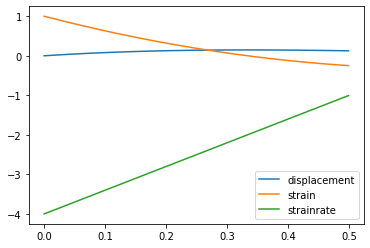

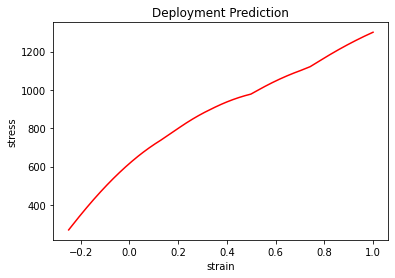

In [10]:
#%% 

Y_pred_150 = []

for i in range(len(data_150)):
    X_test, Y_test = generate_X_and_Y(data_150[i], poly_degree)
    X_test = X_test.cuda()
    Y_test_pred = model(X_test)
    Y_test_pred = Y_test_pred.cpu()
    
    filename_split = re.split('-|_|.xls', filename_150[i])
    temperature = float(filename_split[0])
    strain_rate = float(filename_split[1])    
    title = 'Test Files at Temperature of {}, Strain Rate {}'.format(temperature,strain_rate)
    
    plt.figure()
    plt.plot(data_150[i]['plastic_strain'].to_numpy(),Y_test.detach().numpy(), color='r')
    plt.plot(data_150[i]['plastic_strain'].to_numpy(),Y_test_pred.detach().numpy(), color='b')    
    plt.title(title)
    plt.xlabel('strain')
    plt.ylabel('stress')
    plt.legend(['test values','predicted values'])
    Y_pred_150.append(Y_test_pred)
  
for i in range(len(data_550)):
    X_test, Y_test = generate_X_and_Y(data_550[i], poly_degree)
    X_test = X_test.cuda()
    Y_test_pred = model(X_test)
    Y_test_pred = Y_test_pred.cpu()
    
    filename_split = re.split('-|_|.xls', filename_550[i])
    temperature = float(filename_split[0])
    strain_rate = float(filename_split[1])    
    title = 'Test Files at Temperature of {}, Strain Rate {}'.format(temperature,strain_rate)
    
    plt.figure()
    plt.plot(data_550[i]['plastic_strain'].to_numpy(),Y_test.detach().numpy(), color='r')
    plt.plot(data_550[i]['plastic_strain'].to_numpy(),Y_test_pred.detach().numpy(), color='b')    
    plt.title(title)
    plt.xlabel('strain')
    plt.ylabel('stress')
    plt.legend(['test values','predicted values'])


#%%
t = np.arange(0,0.5,0.001)
x = t**3 - 2*t**2 + t
strain = 3*t**2 - 4*t + 1
strainrate = 6*t - 4

plt.figure(0)
plt.plot(t, x)
plt.plot(t, strain)
plt.plot(t, strainrate)
plt.legend(['displacement','strain','strainrate'])

deployment_temperature = 100 #C
temp = np.full(len(strain),deployment_temperature)
dummy = np.zeros(len(strain))

deploy_np = np.array([strain,temp,strainrate,dummy]).T

deploy_df = pd.DataFrame(deploy_np)
deploy_df.columns = ['plastic_strain','temperature','strain_rate','true_stress']

X_deploy, Y_deploy = generate_X_and_Y(deploy_df, poly_degree)
X_deploy = X_deploy.cuda()
Y_deploy_pred = model(X_deploy)
Y_deploy_pred = Y_deploy_pred.cpu() 

plt.figure()
plt.plot(strain,Y_deploy_pred.detach().numpy(), color='r')
plt.title('Deployment Prediction')
plt.xlabel('strain')
plt.ylabel('stress')





## LSTM | Data Loading and Pre-Processing

**Data Loading:** 

Load the data provided in the Excel Sheets. Dierent Excel sheets
represent the behavior of the material at different strain rates and temperatures.
Each Excel sheet contains the data about the variation of stress with strain. You
may use, just the true stress vs. plastic strain data for the analysis. (You might
have to preprocess the points by removing some points with zero stress and zero
strain).

**Data preprocessing:** 

Preprocess the data and create a list of strain, strain-rate,
temperature and stress.

In [11]:
plastic_strain_tol = 0.01
true_stress_tol = 2
column_names = ['plastic_strain', 'true_stress']
test_temperatures = [150, 550]
# neural network parameters
hidden_dim_1 = 10
hidden_dim_2 = 10
poly_degree = 6
hidden_dim = 3
learning_rate = 3E-4
n_folds = 5
poly_degree = 2

#%%
def read_sort_input(file):
    # import the data from file name
    data = pd.read_excel(file, keep_default_na=False)
    # remove empty columns
    data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
    # grab the file name only to pull metadata
    filename = file.split('/')[-1]
    
    # if plastic strain is available, use it; otherwise use true strain
    if len(data.columns) == 8:        
        stress_strain = data.iloc[:,6:8]
        stress_strain.columns = ['strain', 'stress']
    else:
        stress_strain = data.iloc[:,4:6]
        stress_strain.columns = ['strain', 'stress']
        print(filename)
    
    # remove the data points where both plastic strain and true stress are zero
    index_names = stress_strain[ (stress_strain['strain'] < 0.01) | (stress_strain['stress'] < 20) ].index
    stress_strain.drop(index_names, inplace=True)
    
    stress_strain_np = stress_strain.to_numpy()
    stress_strain = pd.DataFrame({'strain':stress_strain_np[:,0],'stress':stress_strain_np[:,1]})
        
    filename_split = re.split('-|_|.xls', filename)
    temp = float(filename_split[0])
    strain_rate = float(filename_split[1])
    #combining metadata of temperature and strainrate from file name
    tempstrain = pd.DataFrame({'temperature': temp,'strainrate': strain_rate},index=list(range(len(stress_strain.iloc[1:,0])+1)))
    
    # combining strain, stress, temperature, and strainrate
    combined = pd.concat([stress_strain['strain'],tempstrain,stress_strain['stress']], axis=1)
    combined_tensor = torch.tensor(combined.to_numpy(dtype=float)) 
    
    # this next part of the function rearranges the strain data for the LSTM section
    strain = combined['strain'].to_numpy()
    
    # number of strain columns that we want 
    numCol = 5
    
    # start the strain array so that we can append later
    strain_rearrange = np.zeros((1,numCol))
    
    # rearrange the strain so that each row is numCol number of strain values
    # each column iterates one strain value
    for i in range(0,len(strain)-numCol-1):
        row = np.array(strain[i:i+numCol])
        strain_rearrange = np.vstack((strain_rearrange,row))
        
    strain_rearrange_df = pd.DataFrame(strain_rearrange[1:,:])  
    stress_rearrange = combined['stress'][numCol+1:]
    stress_rearrange.reset_index(drop=True, inplace=True)
    
    tempstrain = pd.DataFrame({'temperature': temp,'strainrate': filename_split[1]},index=list(range(len(strain_rearrange)-1)))
    combined_strain = pd.concat([strain_rearrange_df,tempstrain,stress_rearrange], axis=1)
    combined_strain_tensor = torch.tensor(combined_strain.to_numpy(dtype=float)) 
    
    return combined, combined_tensor, combined_strain, combined_strain_tensor

def list_folder_contents(path):
    
    # initialize an empty list
    entries = []
    
    # loop through the folder to retieve its contents
    for entry in os.listdir(path):
        entries.append(entry)
        
    # return the folder contents
    return entries

def list_to_tensor(listdata):
    tensordata = listdata[0]
    for i in range(len(listdata)-1):
        tensordata = torch.cat((tensordata, listdata[i+1]))
        
    return tensordata

In [12]:
# pull all folders in the input path location
folder_names = list_folder_contents(path)

# initiate list for all of the preprocessed data
alldata = []
alldata_tensor = []
alldata_strainrearranged = []
alldata_strainrearranged_tensor = []

# look through all folders
for folder in folder_names:
    filename = list_folder_contents(path + '/' + folder)
    
    # look at all files in each folder
    for file in filename:
      print(path + '/' + folder + '/' + file)
      # read and preprocess each file in all folders
      combined, combined_tensor, combined_strain, combined_strain_tensor = read_sort_input(path + '/' + folder + '/' + file)
      # combine data into a single list
      alldata_strainrearranged.append(combined_strain)
      alldata_strainrearranged_tensor.append(combined_strain_tensor)

/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/550C/550_.0001.xls


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/550C/550_.001.xls


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/550C/550_.01.xls


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/250C/250-0.001.xls
/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/250C/250-0.01.xls


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/250C/250-0.0001.xls


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/250C/250-0.1.xls
/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/150C/150-0.001.xls
/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/150C/150-0.01.xls


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/150C/150-0.0001.xls


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/150C/150-0.1.xls
/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/350C/350-0.01.xls
/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/350C/350-0.001.xls


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/350C/350-0.1.xls
/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/350C/350-0.0001.xls


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/50C/50-0.01.xls


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/50C/50-0.001.xls


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/50C/50-0.1.xls
/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/50C/50-0.0001.xls


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/300C/300-0.1.xls
/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/300C/300-0.001.xls
/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/300C/300-0.01.xls


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/300C/300-0.0001.xls


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/500C/500_.0001.xls


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/500C/500_.01.xls
/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/500C/500_.001.xls


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/450C/450_.0001.xls


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/450C/450_.001.xls


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/450C/450_.01.xls
/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/100C/100-0.01.xls


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/100C/100-0.001.xls
/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/100C/100-0.1.xls


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/100C/100-0.0001.xls


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/200C/200-0.001.xls
/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/200C/200-0.01.xls


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/200C/200-0.0001.xls


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/200C/200-0.1.xls
/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/600C/600_.001.xls


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/600C/600_.01.xls
/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/600C/600_.0001.xls


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/650C/650_.0001.xls


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/650C/650_.001.xls
/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/650C/650_.01.xls


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## LSTM | Data Split

**Data split:** 

Split the data pertaining into three parts (training, validation and
testing). Two temperatures can be selected as test data. Choose a strategy to
divide the data for training and validation (a typical strategy is to split the data
into 60% training and 40% testing, or 80-20). Justify the strategy you select. Also,
use k-fold cross validation strategy for training.

In [14]:
# strain rearranged here denotes creating a tensor with 5 sequential strain datapoints
# the following lines reformat the tensor into a pandas dataframe in the order:
# [ strain1, strain2, strain3, strain4, strain5, temperature, strain_rate, stress]
# the LSTM model needs these additional point to recognize the dependence of the stress 
# on the previous strain values
alldata_strainrearranged = list_to_tensor(alldata_strainrearranged_tensor)
alldata_strainrearranged_view = alldata_strainrearranged.numpy()
alldata_strainrearranged_df = pd.DataFrame(alldata_strainrearranged_view)
alldata_strainrearranged_df.columns = ['strain1','strain2','strain3','strain4','strain5','temperature','strain_rate', 'true_stress']

#%%
# split 'all_data' into train and test
# choose 2 temperatures as test data as per the project requirements
all_data_train = alldata_strainrearranged_df.loc[~alldata_strainrearranged_df['temperature'].isin(test_temperatures)]
all_data_test = alldata_strainrearranged_df.loc[alldata_strainrearranged_df['temperature'].isin(test_temperatures)]

X = all_data_train.values
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
X_unscale = min_max_scaler.inverse_transform(X_scaled)
all_data_train = pd.DataFrame(X_scaled)
all_data_train.columns = ['strain1','strain2','strain3','strain4','strain5','temperature','strain_rate', 'true_stress']

## LSTM | Neural Network

**LSTMs:** 

build a LSTM network to predict 
ow stress for a given strain, strain-rate
and temperature. Do a study on the parameter study on the roll-out of the LSTM
required. Also, you might have to add zeros after the failure point to recognize the
failure of the material.

In [15]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [16]:
lstm_model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

# define the k-fold
k_fold = KFold(n_splits = n_folds, shuffle=False, random_state=1)

for train_index, validate_index in k_fold.split(all_data_train):
  train_fold = all_data_train.iloc[train_index]
  validate_fold = all_data_train.iloc[validate_index]

  train_input = train_fold.iloc[:,[0,1,2,3,4,5,6]].to_numpy()
  train_output = train_fold.iloc[:,7].to_numpy()

  train_input = torch.tensor(train_input).float()
  train_output = torch.tensor(train_output).float()

  validate_input = validate_fold.iloc[:,[0,1,2,3,4,5,6]].to_numpy()
  validate_output = validate_fold.iloc[:,7].to_numpy()

  validate_input = torch.tensor(validate_input).float()
  validate_output = torch.tensor(validate_output).float()
    
  for k in range(len(train_input)):

    fold_loss = 0
    optimizer.zero_grad()
    lstm_model.hidden_cell = (torch.zeros(1, 1, lstm_model.hidden_layer_size),
                    torch.zeros(1, 1, lstm_model.hidden_layer_size))

    y_pred = lstm_model(train_input[k])
    single_loss = loss_function(y_pred, train_output[k])
    single_loss.backward()
    optimizer.step()

    if k % 10000 == 99:
      text1 = 'Step: {} of {}, Loss: {}'.format(k, len(train_input), single_loss)
      print(text1)

  for i in range(len(validate_input)):
    y_pred_validate = lstm_model(validate_input[i])
    validate_loss = loss_function(y_pred_validate, validate_output[i])

    fold_loss += validate_loss

  text2 = 'Fold error is {}'.format(fold_loss/len(validate_input))
  print('-----------')
  print(text2)
  print('-----------')


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Step: 99 of 76104, Loss: 3.5741420560952974e-06
Step: 10099 of 76104, Loss: 2.7391645289753797e-06
Step: 20099 of 76104, Loss: 6.249218859011307e-05
Step: 30099 of 76104, Loss: 0.00011029974120901898
Step: 40099 of 76104, Loss: 7.569333888568508e-07
Step: 50099 of 76104, Loss: 3.1451136237592436e-06
Step: 60099 of 76104, Loss: 0.00010987447603838518
Step: 70099 of 76104, Loss: 0.00017630468937568367
-----------
Fold error is 0.028128590434789658
-----------
Step: 99 of 76105, Loss: 6.731267490067694e-07
Step: 10099 of 76105, Loss: 1.6832065057315049e-06
Step: 20099 of 76105, Loss: 1.5060368241393007e-05
Step: 30099 of 76105, Loss: 0.00012404490553308278
Step: 40099 of 76105, Loss: 2.4524269974790514e-06
Step: 50099 of 76105, Loss: 2.1187859147175914e-06
Step: 60099 of 76105, Loss: 8.79633953445591e-05
Step: 70099 of 76105, Loss: 0.00012730699381791055
-----------
Fold error is 0.019004350528120995
-----------
Step: 99 of 76105, Loss: 3.5386221952649066e-08
Step: 10099 of 76105, Loss: 7

## LSTM | Testing and Deployment

**Deployment:** 

The true stress and true strain results are obtained for a sheet metal.
Tensile testing is performed on a small rectangular strip, 6cm in length and the jaws
holding one end of the specimen and the other side is pulled by a displacement of
x. For all the experiments in the data, displacement is such a way that the strain
rate is constant through out the process. However, in forming strain rate varies
non-linearly. Example: your displacement could be represented as x = t^3 - 2t^2 + t.
Then, predict the stress-strain curve for this profile of displacements. (Hint: you
need to use the Hooke's law and related components to convert the x to strains and
strain rates and then eventually computing the stress strain curve for same).

**Presenting results:** 

Compare the results you obtain for training, validation and
testing data on the naive learning model and the LSTM. Visualize the stress-strain
curves of the predicted (both) and the actual. Also, visualize the stress-strain curve
for the deployment for both the learning cases.


**150C Test Data**

-----------------------------
/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/150C/150-0.001.xls
-----------------------------


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


-----------------------------
/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/150C/150-0.01.xls
-----------------------------


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


-----------------------------
/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/150C/150-0.0001.xls
-----------------------------


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


-----------------------------
/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/150C/150-0.1.xls
-----------------------------


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


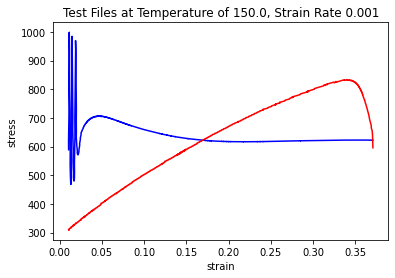

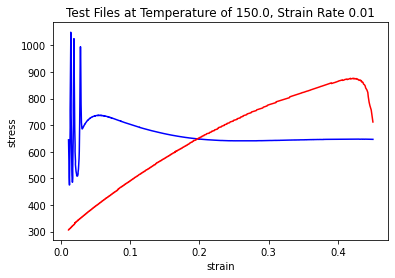

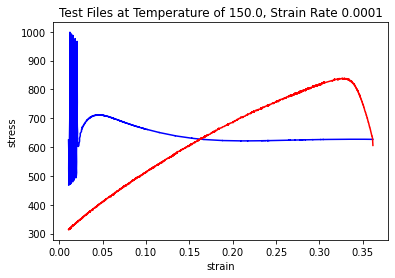

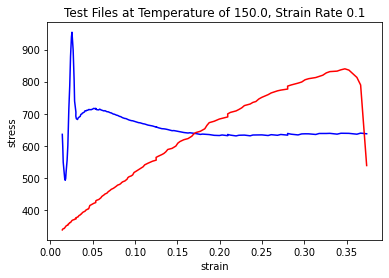

In [17]:
path_150 = r'/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/150C'
path_550 = r'/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/550C'

# initiate list for all of the preprocessed data
data150_strainrearranged = []
data150_strainrearranged_tensor = []

filename = list_folder_contents(path_150)

# look at all files in each folder
for file in filename:
  print('-----------------------------')
  print(path_150 + '/' + file)
  print('-----------------------------')
  # read and preprocess each file in all folders
  combined, combined_tensor, combined_strain, combined_strain_tensor = read_sort_input(path_150 + '/' + file)

  # strain rearranged here denotes creating a tensor with 5 sequential strain datapoints
  # the following lines reformat the tensor into a pandas dataframe in the order:
  # [ strain1, strain2, strain3, strain4, strain5, temperature, strain_rate, stress]
  # the LSTM model needs these additional point to recognize the dependence of the stress 
  # on the previous strain values
  data150_strainrearranged_view = combined_strain_tensor.numpy()
  data150_strainrearranged_df = pd.DataFrame(data150_strainrearranged_view)
  data150_strainrearranged_df.columns = ['strain1','strain2','strain3','strain4','strain5','temperature','strain_rate', 'true_stress']

  # scaling the values of data, both input and output
  X = data150_strainrearranged_df.values
  min_max_scaler = preprocessing.MinMaxScaler()
  X_scaled = min_max_scaler.fit_transform(X)
  X_unscale = min_max_scaler.inverse_transform(X_scaled)
  data150_validate = pd.DataFrame(X_scaled)
  data150_validate.columns = ['strain1','strain2','strain3','strain4','strain5','temperature','strain_rate', 'true_stress']

  # seperating the inputs [strains, temp, strain rate] from the outputs [stress]
  data150_validate_input = data150_validate.iloc[:,[0,1,2,3,4,5,6]].to_numpy()
  data150_validate_output = data150_validate.iloc[:,7].to_numpy()

  # convert to tensor
  data150_validate_input = torch.tensor(data150_validate_input).float()
  data150_validate_output = torch.tensor(data150_validate_output).float()

  # initate the prediction array
  data150_predY = np.empty(8)

  # iterate through the input to predict the outputs
  for i in range(len(data150_validate_input)):
    data150_pred_validate = lstm_model(data150_validate_input[i])
    data150_scaled = np.concatenate((data150_validate_input[i],data150_pred_validate.detach().numpy()))
    data150_predY = np.vstack((data150_predY,data150_scaled))

  # drop the first line which is the empy row
  data150_predY = data150_predY[1:,:]
  # transform back to real space
  data150_unscale = min_max_scaler.inverse_transform(data150_predY)

  filename_split = re.split('-|_|.xls', file)
  temperature = float(filename_split[0])
  strain_rate = float(filename_split[1])
  title = 'Test Files at Temperature of {}, Strain Rate {}'.format(temperature,strain_rate)

  plt.figure()
  plt.plot(data150_unscale[:,4],data150_unscale[:,7], color='b')
  plt.plot(X[:,4],X[:,7], color='r')
  plt.title(title)
  plt.xlabel('strain')
  plt.ylabel('stress')

**550C Test Data**

-----------------------------
/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/550C/550_.0001.xls
-----------------------------


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(12203, 8)
(12203, 8)
-----------------------------
/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/550C/550_.001.xls
-----------------------------


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(1851, 8)
(1851, 8)
-----------------------------
/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW3/DM/550C/550_.01.xls
-----------------------------


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(2233, 8)
(2233, 8)


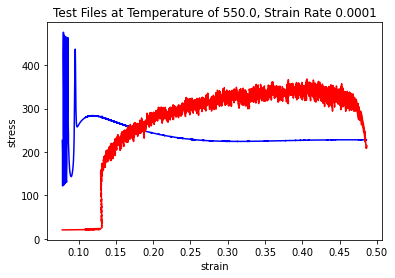

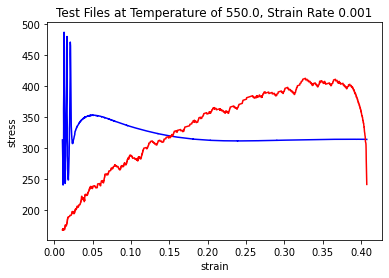

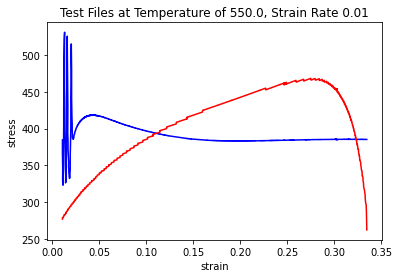

In [18]:
# initiate list for all of the preprocessed data
data550_strainrearranged = []
data550_strainrearranged_tensor = []

filename = list_folder_contents(path_550)

# look at all files in each folder
for file in filename:
  print('-----------------------------')
  print(path_550 + '/' + file)
  print('-----------------------------')
  # read and preprocess each file in all folders
  combined, combined_tensor, combined_strain, combined_strain_tensor = read_sort_input(path_550 + '/' + file)

  # strain rearranged here denotes creating a tensor with 5 sequential strain datapoints
  # the following lines reformat the tensor into a pandas dataframe in the order:
  # [ strain1, strain2, strain3, strain4, strain5, temperature, strain_rate, stress]
  # the LSTM model needs these additional point to recognize the dependence of the stress 
  # on the previous strain values
  data550_strainrearranged_view = combined_strain_tensor.numpy()
  data550_strainrearranged_df = pd.DataFrame(data550_strainrearranged_view)
  data550_strainrearranged_df.columns = ['strain1','strain2','strain3','strain4','strain5','temperature','strain_rate', 'true_stress']

  X = data550_strainrearranged_df.values
  min_max_scaler = preprocessing.MinMaxScaler()
  X_scaled = min_max_scaler.fit_transform(X)
  X_unscale = min_max_scaler.inverse_transform(X_scaled)
  data550_validate = pd.DataFrame(X_scaled)
  data550_validate.columns = ['strain1','strain2','strain3','strain4','strain5','temperature','strain_rate', 'true_stress']

  data550_validate_input = data550_validate.iloc[:,[0,1,2,3,4,5,6]].to_numpy()
  data550_validate_output = data550_validate.iloc[:,7].to_numpy()

  data550_validate_input = torch.tensor(data550_validate_input).float()
  data550_validate_output = torch.tensor(data550_validate_output).float()

  data550_predY = np.empty(8)

  for i in range(len(data550_validate_input)):
    data550_pred_validate = lstm_model(data550_validate_input[i])
    data550_scaled = np.concatenate((data550_validate_input[i],data550_pred_validate.detach().numpy()))
    data550_predY = np.vstack((data550_predY,data550_scaled))

  data550_predY = data550_predY[1:,:]
  data550_unscale = min_max_scaler.inverse_transform(data550_predY)

  print(data550_unscale.shape)
  print(X.shape)

  filename_split = re.split('-|_|.xls', file)
  temperature = float(filename_split[0])
  strain_rate = float(filename_split[1])
  title = 'Test Files at Temperature of {}, Strain Rate {}'.format(temperature,strain_rate)

  plt.figure()
  plt.plot(data550_unscale[:,4],data550_unscale[:,7], color='b')
  plt.plot(X[:,4],X[:,7], color='r')
  plt.title(title)
  plt.xlabel('strain')
  plt.ylabel('stress')

**Deployment**

Text(0.5, 1.0, 'Deployment Prediction')

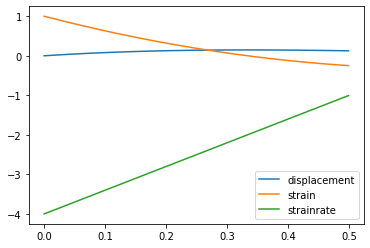

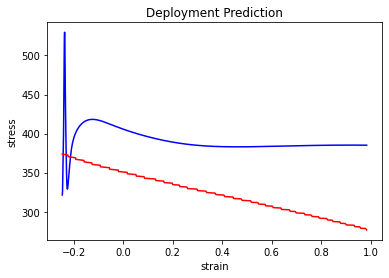

In [19]:
#%%
t = np.arange(0,0.5,0.001)
x = t**3 - 2*t**2 + t
strain = 3*t**2 - 4*t + 1
strainrate = 6*t - 4

# number of strain columns that we want 
numCol = 5

deployment_temperature = 100 #C
temp = np.full(len(strain)-numCol-1,deployment_temperature)
dummy = np.zeros(len(strain))

# start the strain array so that we can append later
strain_rearrange = np.zeros((1,numCol))

# rearrange the strain so that each row is numCol number of strain values
# each column iterates one strain value
for i in range(0,len(strain)-numCol-1):
    row = np.array(strain[i:i+numCol])
    strain_rearrange = np.vstack((strain_rearrange,row))
    
strain_rearrange_df = pd.DataFrame(strain_rearrange[1:,:])  
stress_rearrange = combined['stress'][numCol+1:]
stress_rearrange.reset_index(drop=True, inplace=True)

tempstrain = pd.DataFrame({'temperature': temp,'strainrate': filename_split[1]},index=list(range(len(strain_rearrange)-1)))
combined_strain = pd.concat([strain_rearrange_df,tempstrain,stress_rearrange], axis=1)
combined_strain_tensor = torch.tensor(combined_strain.to_numpy(dtype=float))

deploy_strainrearranged_view = combined_strain_tensor.numpy()
deploy_strainrearranged_df = pd.DataFrame(deploy_strainrearranged_view)
deploy_strainrearranged_df.columns = ['strain1','strain2','strain3','strain4','strain5','temperature','strain_rate', 'true_stress']

X = deploy_strainrearranged_df.values
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
X_unscale = min_max_scaler.inverse_transform(X_scaled)
deploy_validate = pd.DataFrame(X_scaled)
deploy_validate.columns = ['strain1','strain2','strain3','strain4','strain5','temperature','strain_rate', 'true_stress']

deploy_validate_input = deploy_validate.iloc[:,[0,1,2,3,4,5,6]].to_numpy()
deploy_validate_output = deploy_validate.iloc[:,7].to_numpy()

deploy_validate_input = torch.tensor(deploy_validate_input).float()
deploy_validate_output = torch.tensor(deploy_validate_output).float()

deploy_predY = np.empty(8)

for i in range(len(deploy_validate_input)):
  deploy_pred_validate = lstm_model(deploy_validate_input[i])
  deploy_scaled = np.concatenate((deploy_validate_input[i],deploy_pred_validate.detach().numpy()))
  deploy_predY = np.vstack((deploy_predY,deploy_scaled))

deploy_predY = deploy_predY[1:,:]
deploy_unscale = min_max_scaler.inverse_transform(deploy_predY)

plt.figure(0)
plt.plot(t, x)
plt.plot(t, strain)
plt.plot(t, strainrate)
plt.legend(['displacement','strain','strainrate'])

plt.figure()
plt.plot(deploy_unscale[:,4],deploy_unscale[:,7], color='b')
plt.plot(X[:,4],X[:,7], color='r')
plt.title(title)
plt.xlabel('strain')
plt.ylabel('stress')
plt.title('Deployment Prediction')